This notebook demonstrates:
* Opening landsat data saved on disk
* Manipulating landsat dataset
* Plotting landsat data

This notebook demonstrates:
* Opening landsat data saved on disk
* Manipulating landsat dataset
* Plotting landsat data

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import geopandas as gpd

/home/caprice/micromamba/envs/summerfog/lib/python3.12/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


files = sorted(glob.glob("*.nc"))
files

In [ ]:

#"/mnt/c/Users/isabe/FILES/Documents/FHL Summer 2025/2022-09-29T19_02_11.597592000.nc"

"C:\Users\isabe\FILES\Documents\FHL Summer 2025\2022-09-29T19_01_47.715049000.nc"

In [13]:
fn = "2022-09-29T19:02:11.597592000.nc"


#file path

In [14]:
ds = xr.open_dataset(fn)

ds

In [ ]:
ds


<xarray.Dataset> Size: 145MB
Dimensions:      (y: 2335, x: 1678)
Coordinates:
  * y            (y) float64 19kB 5.42e+06 5.42e+06 ... 5.35e+06 5.35e+06
  * x            (x) float64 13kB 4.75e+05 4.75e+05 ... 5.253e+05 5.253e+05
    time         datetime64[ns] 8B ...
Data variables: (12/20)
    spatial_ref  int32 4B ...
    qa           (y, x) int16 8MB ...
    red          (y, x) uint16 8MB ...
    blue         (y, x) uint16 8MB ...
    drad         (y, x) int16 8MB ...
    emis         (y, x) int16 8MB ...
    ...           ...
    swir16       (y, x) uint16 8MB ...
    swir22       (y, x) uint16 8MB ...
    coastal      (y, x) uint16 8MB ...
    qa_pixel     (y, x) uint16 8MB ...
    qa_radsat    (y, x) uint16 8MB ...
    qa_aerosol   (y, x) uint8 4MB ...

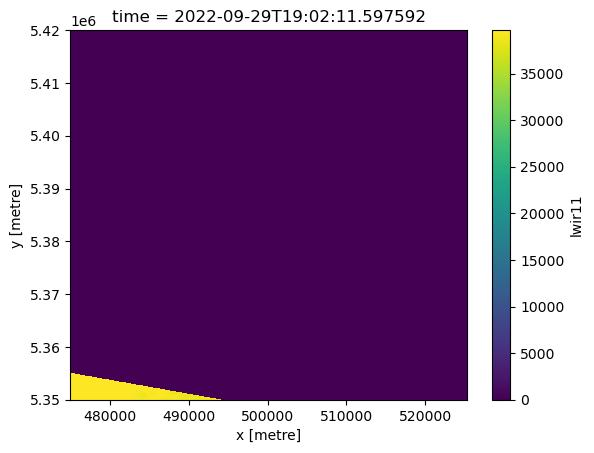

In [17]:
ds['lwir11'].plot()




In [20]:
import rioxarray

In [25]:
ds = ds.rio.write_crs('EPSG:32610')

In [27]:
dslowres = ds.rio.reproject('EPSG:32610', resolution=200)
dslowres = dslowres.rio.reproject('EPSG:4326')

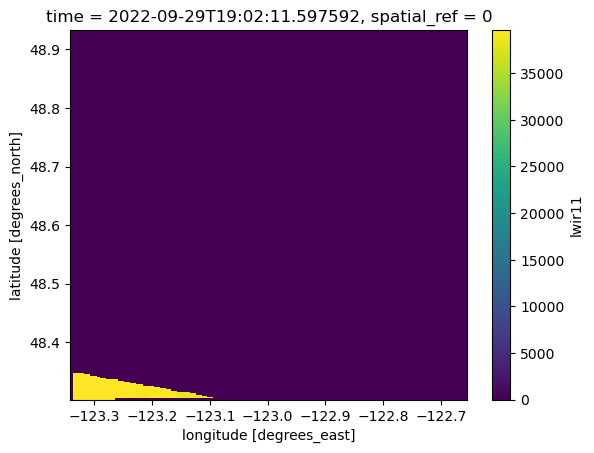

In [29]:
dslowres['lwir11'].plot()

# Create visible image from SWIR, NIR, BLUE

In [8]:
# Normalize 3 bands
ds['swir16_normalized'] = ds['swir16'] / np.max(ds['swir16'])
ds['nir08_normalized'] = ds['nir08'] / np.max(ds['nir08'])
ds['blue_normalized'] = ds['blue'] / np.max(ds['blue'])

# Combine bands into an RGB image
rgb_image = np.stack([
    ds['swir16_normalized'].values,
    ds['nir08_normalized'].values,
    ds['blue_normalized'].values
], axis=-1)

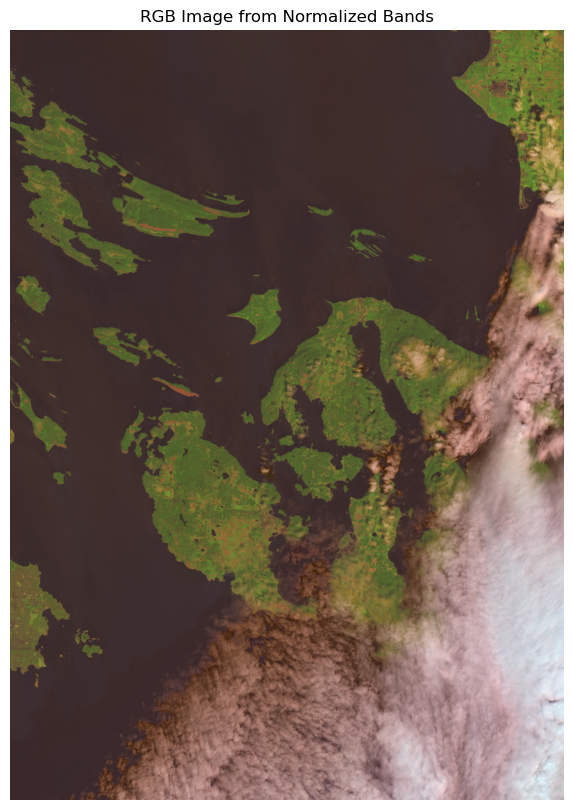

In [9]:
# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')  # Remove axes for better visualization
plt.title("RGB Image from Normalized Bands")
plt.show()

# Create visible image from RGB bands

In [10]:
# Normalize R, G, B bands
ds["red_normalized"] = ds["red"] / np.max(ds["red"])
ds["blue_normalized"] = ds["blue"] / np.max(ds["blue"])
ds["green_normalized"] = ds["green"] / np.max(ds["green"])

# Create RGB image
rgb_image = np.stack([
    ds['red_normalized'].values,
    ds['green_normalized'].values,
    ds['blue_normalized'].values
], axis=-1)

In [11]:
# Trim out highest reflectance values
for i in range(3):
    P = np.percentile(rgb_image[:, :, i], [1, 85])
    rgb_image[:, :, i] = (rgb_image[:, :, i] - P[0]) / np.diff(P)
    rgb_image[:, :, i] = np.clip(rgb_image[:, :, i], 0, 1)

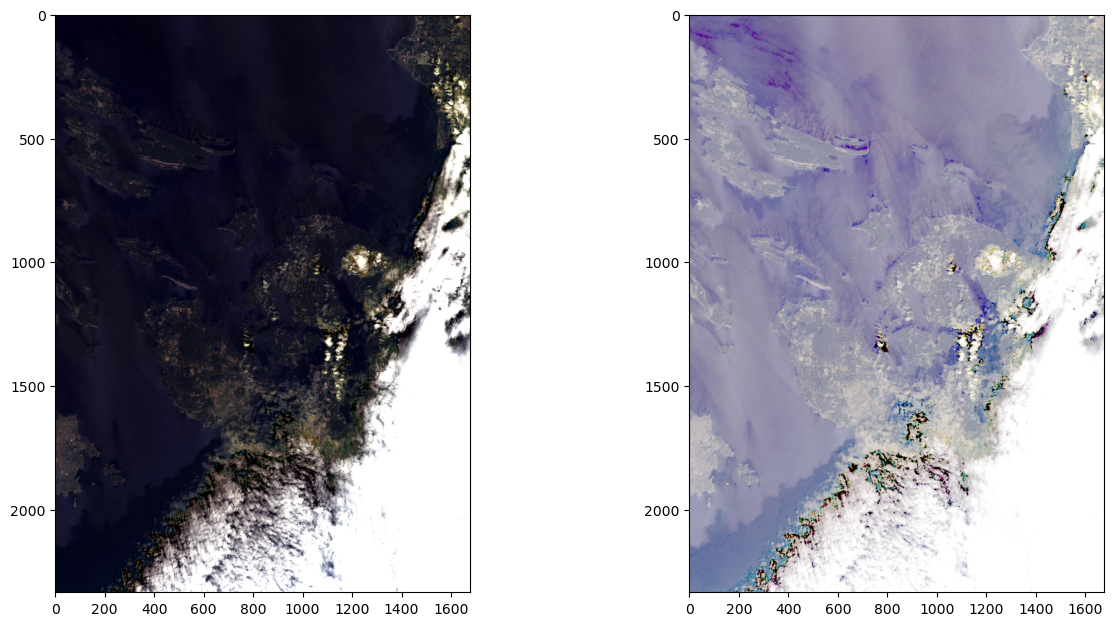

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15,7.5))
axes[0].imshow(rgb_image)
axes[1].imshow(rgb_image ** 0.2)
plt.show()

# Create temperature band from lwir11 band

In [13]:
# These values are retrieved from Page 12 in this handbook: 
# https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v6.pdf
lwir_scale = 0.00341802
lwir_offset = 149.0

In [14]:
temperature = ds["lwir11"].astype("float")
temperature *= lwir_scale
temperature += lwir_offset
celsius = temperature - 273.15
ds['temperature_degC'] = celsius


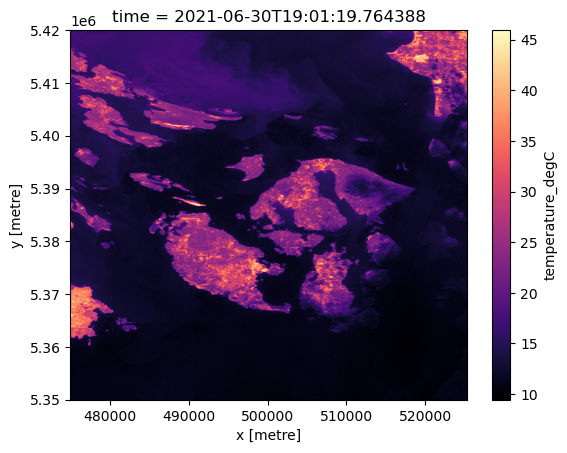

In [15]:
ds['temperature_degC'].plot(cmap="magma")

# Create NDVI and NDWI indices

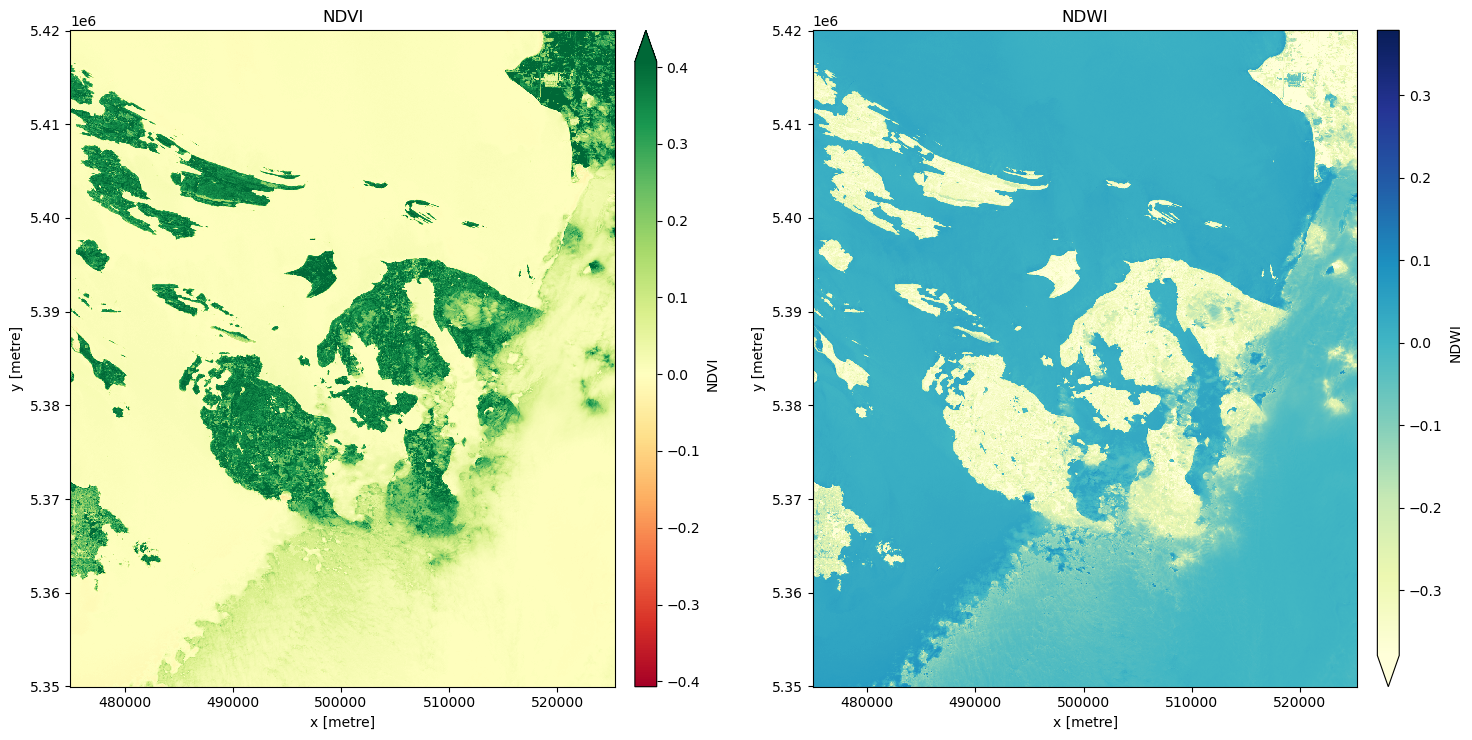

In [16]:
green = ds["green"].astype("float")
red = ds["red"].astype("float")
nir = ds["nir08"].astype("float")

ndvi = (nir - red) / (nir + red)
ndwi = (green - nir) / (green + nir)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5))
axes = axes.flatten()

ndvi.plot.imshow(ax=axes[0], robust=True, cmap="RdYlGn", add_colorbar=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "NDVI"})
axes[0].set_title("NDVI");

ndwi.plot.imshow(ax=axes[1], robust=True, cmap="YlGnBu", add_colorbar=True, cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "NDWI"})
axes[1].set_title("NDWI");

plt.tight_layout()

# Plot an image with shorelines

In [17]:
shorelines = gpd.read_file('ShoreZone_Inventory_-_Shoreline_type.geojson').to_crs('EPSG:32610')

In [18]:
temperature_degC = ds['temperature_degC'].rio.set_crs('EPSG:32610')

In [19]:
temperature_degC_clipped_sanjuan = temperature_degC.rio.clip_box(
    minx = 485000,
    miny = 5365000,
    maxx = 505000,
    maxy = 5390000,
)

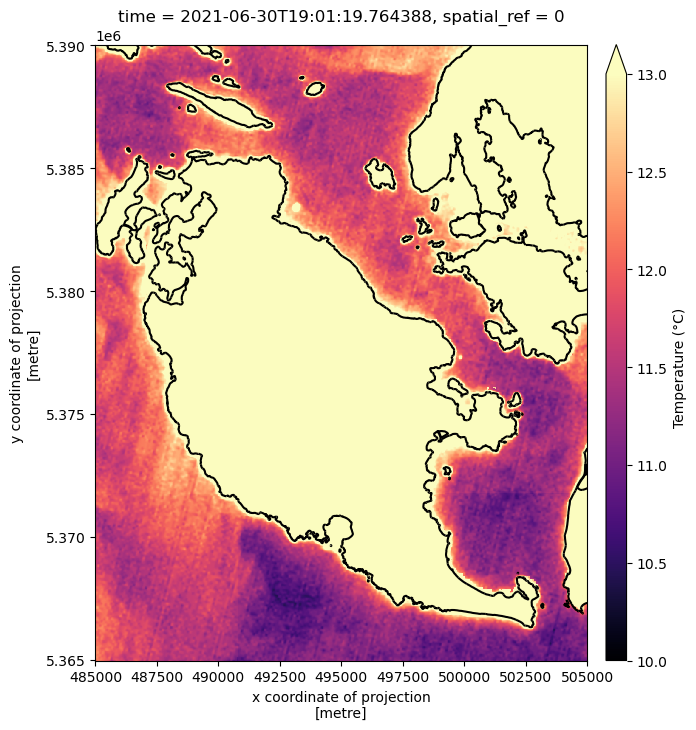

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import box
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
temperature_degC_clipped_sanjuan.plot.imshow(
    cmap="magma", 
    cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "Temperature (°C)"}, 
    vmin=10, 
    vmax=13
)
gpd.clip(
    shorelines,
    mask = box(*temperature_degC_clipped_sanjuan.rio.bounds())
).plot(ax=ax, color='black', linestyle='-')
plt.show()

# Create temperature band from trad band

This isn't producing reasonable values. We're doing something wrong here.

In [44]:
trad_filtered = ds['trad'].where(ds['trad'] != -9999)

In [45]:
trad_filtered = trad_filtered * 0.001
trad_TB = 1321.08 / np.log(
    (774.89 / trad_filtered) + 1
)
trad_TB_degC = trad_TB - 273.15 # convert from K to degC

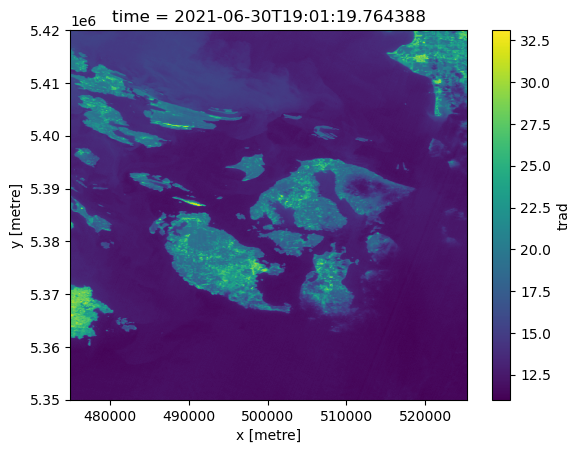

In [46]:
trad_TB_degC.plot()

Modify the colormap min and max so that we can see the temperatures around San Juan better. We did this same thing for the lwir-derived temperature plots above.

In [47]:
trad_TB_degC_clipped = trad_TB_degC.rio.set_crs('EPSG:32610').rio.clip_box(
    minx = 485000,
    miny = 5365000,
    maxx = 505000,
    maxy = 5390000,
)

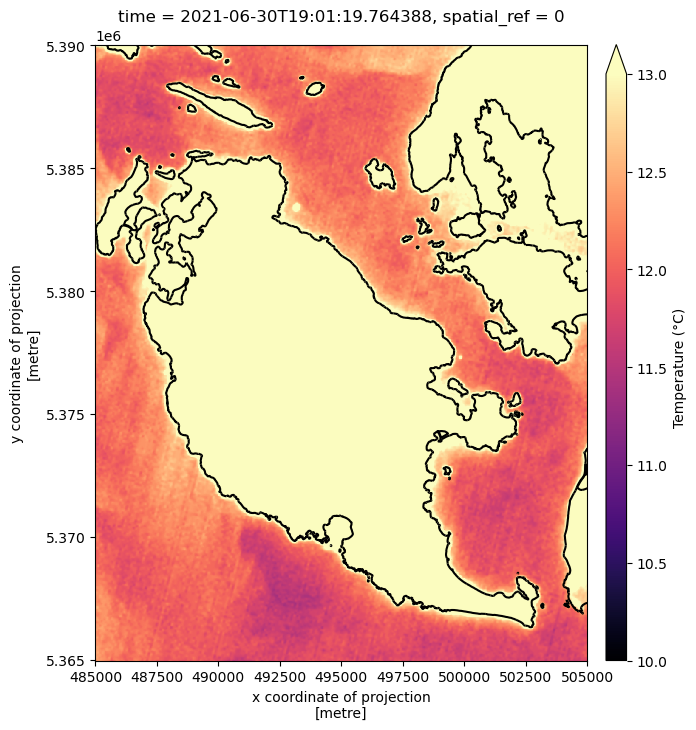

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')
trad_TB_degC_clipped.plot.imshow(
    cmap="magma", 
    cbar_kwargs={"aspect": 30, "pad": 0.03, "label": "Temperature (°C)"}, 
    vmin=10, 
    vmax=13
)
gpd.clip(
    shorelines,
    mask = box(*trad_TB_degC_clipped.rio.bounds())
).plot(ax=ax, color='black', linestyle='-')
plt.show()

# Plot all downloaded scenes

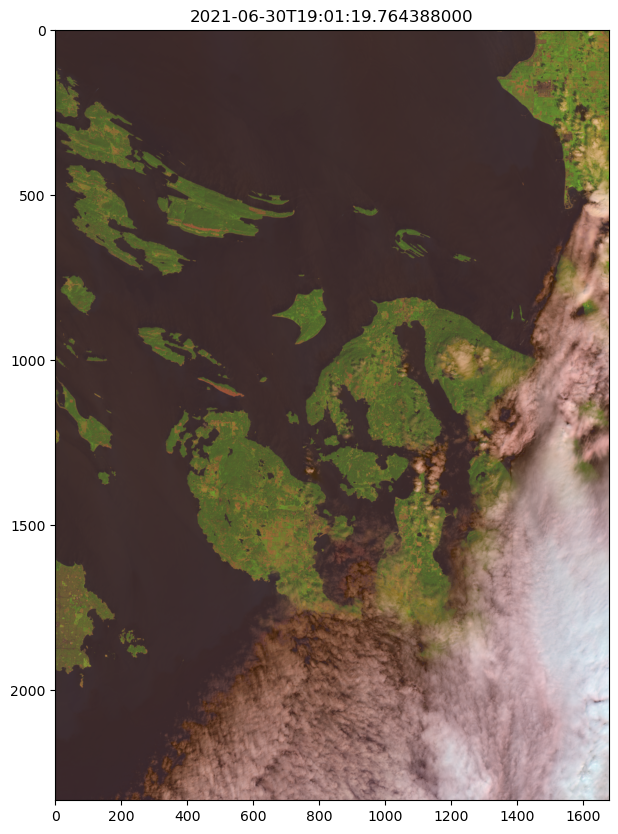

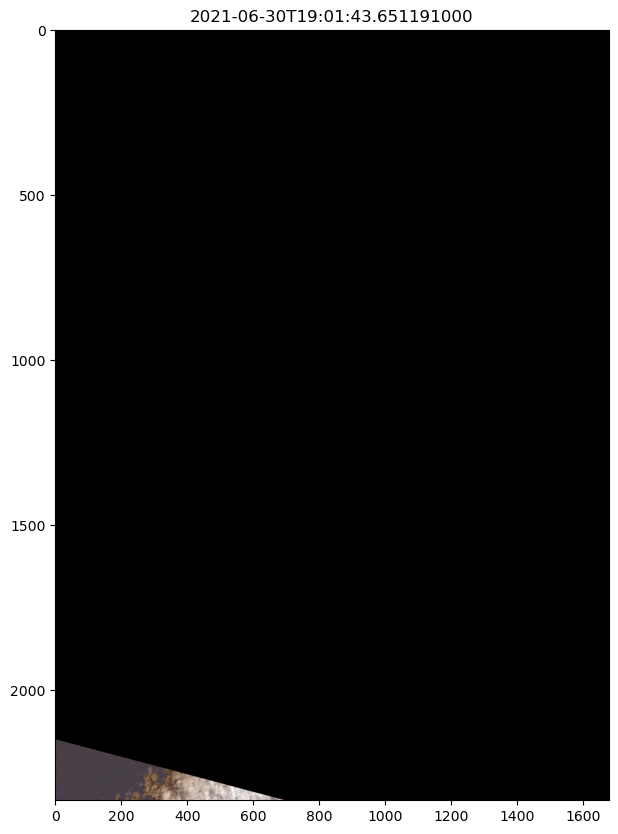

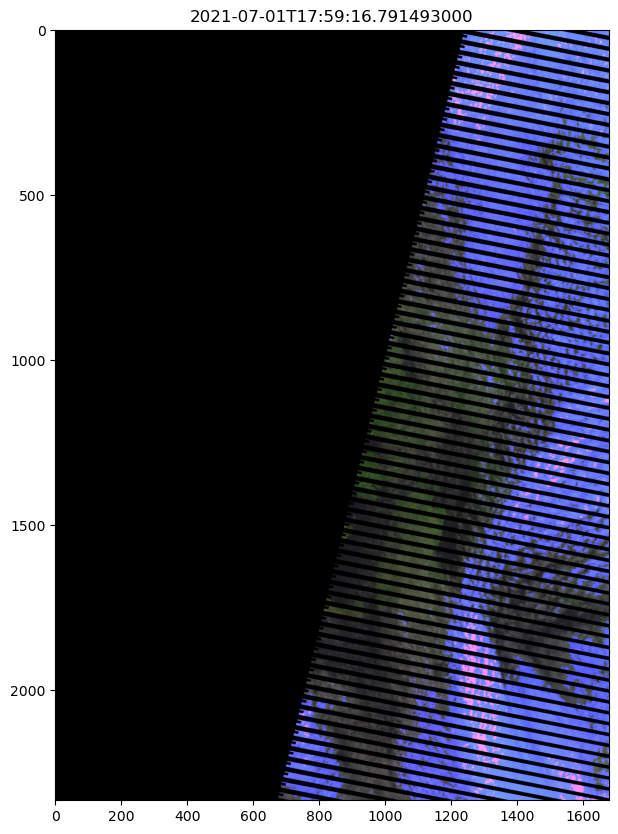

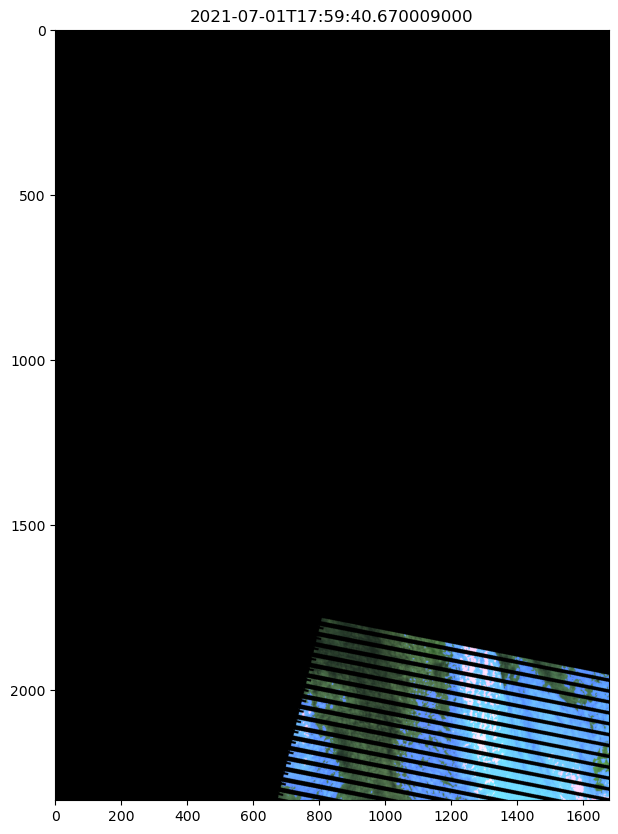

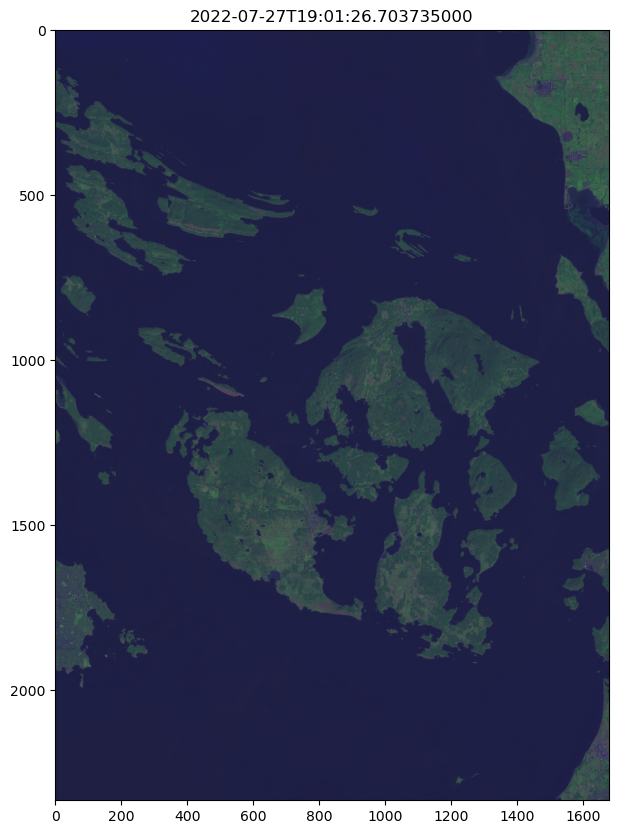

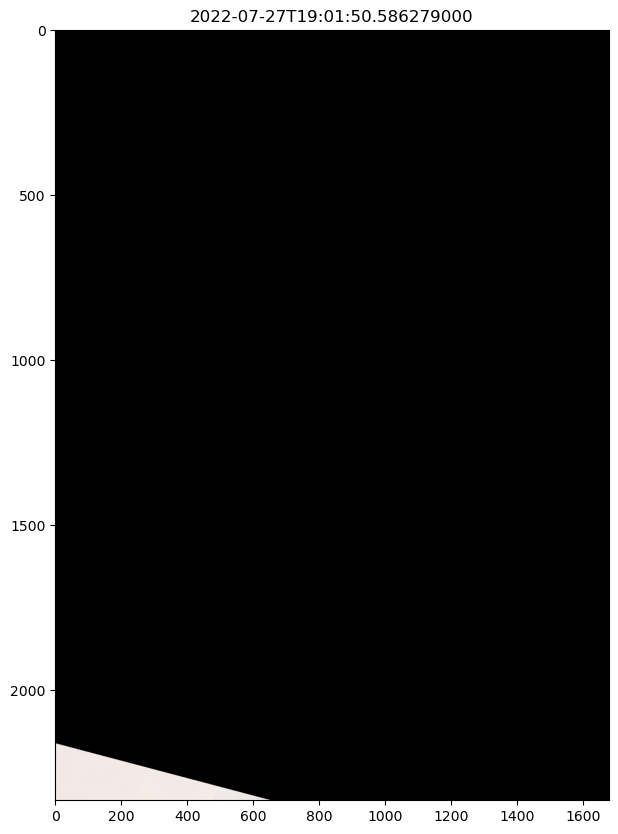

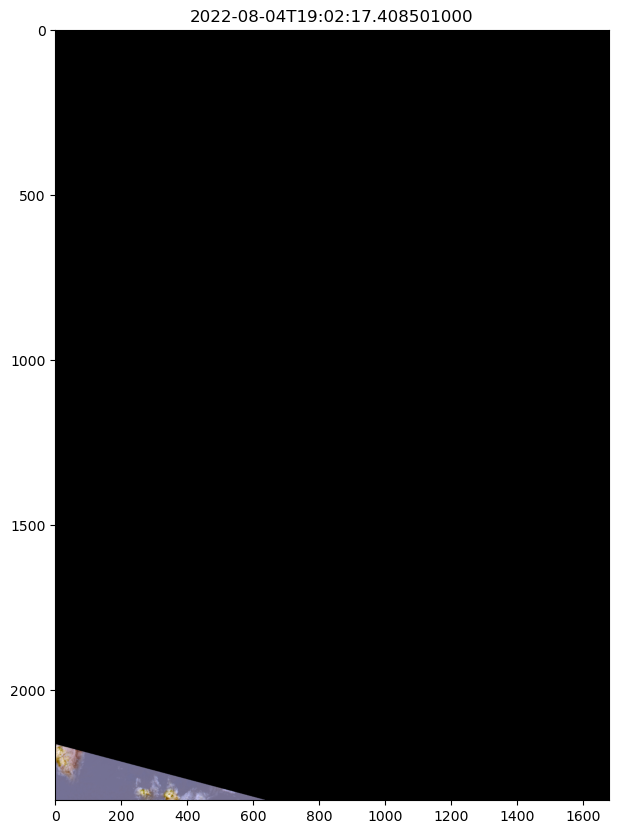

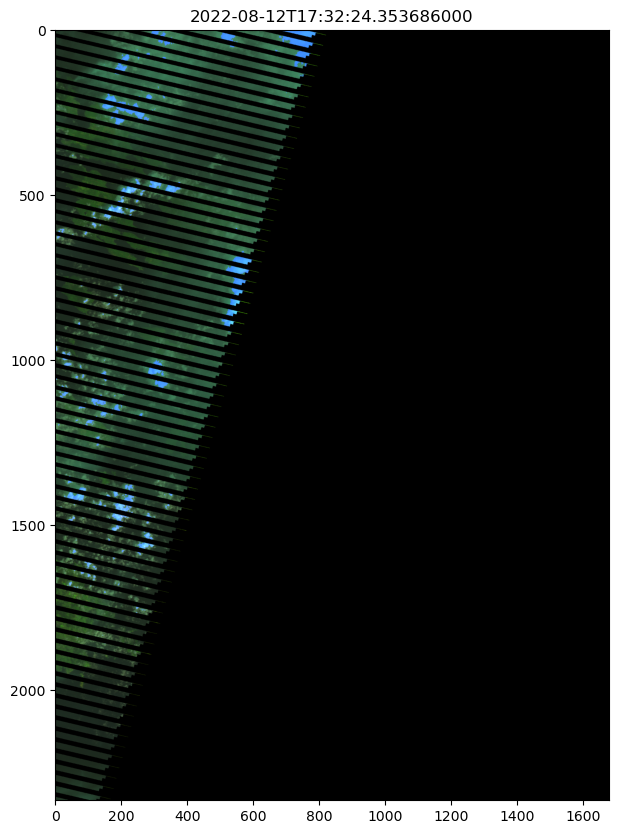

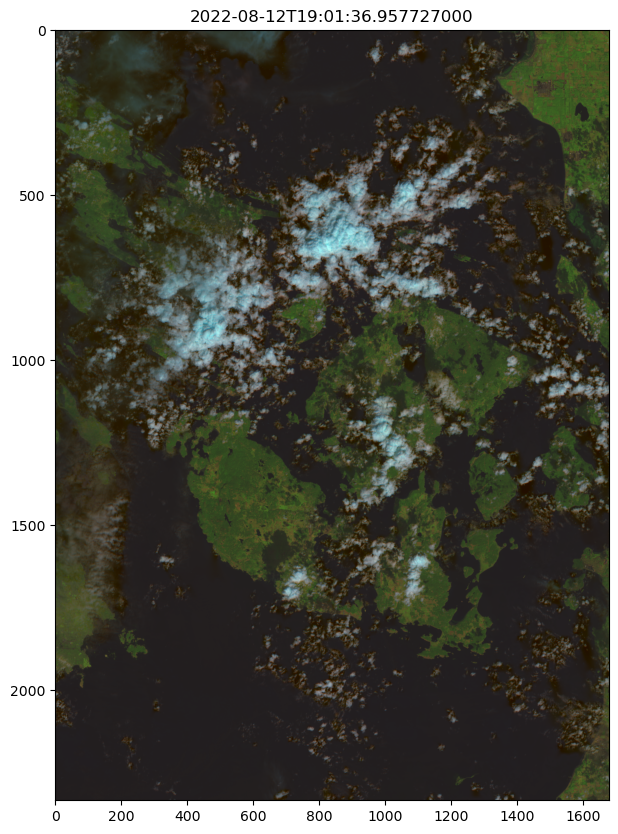

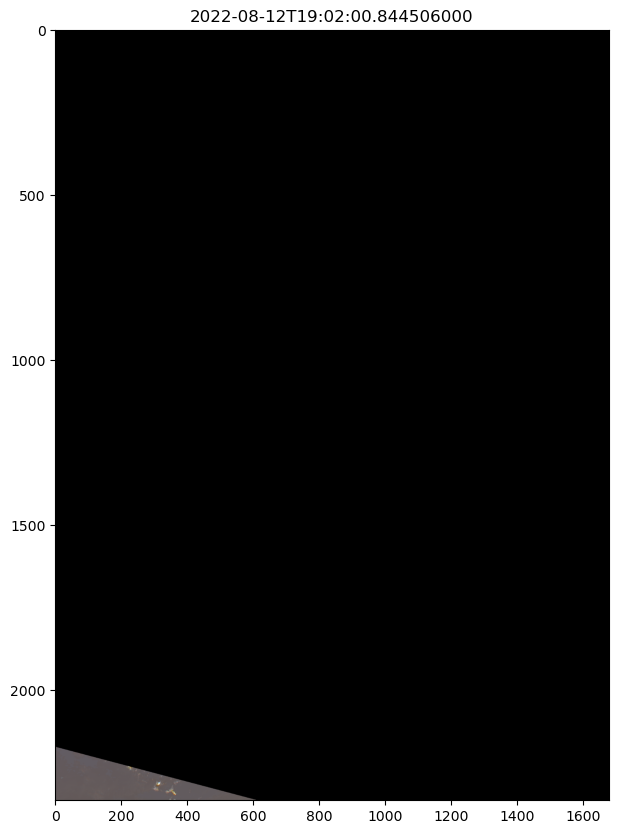

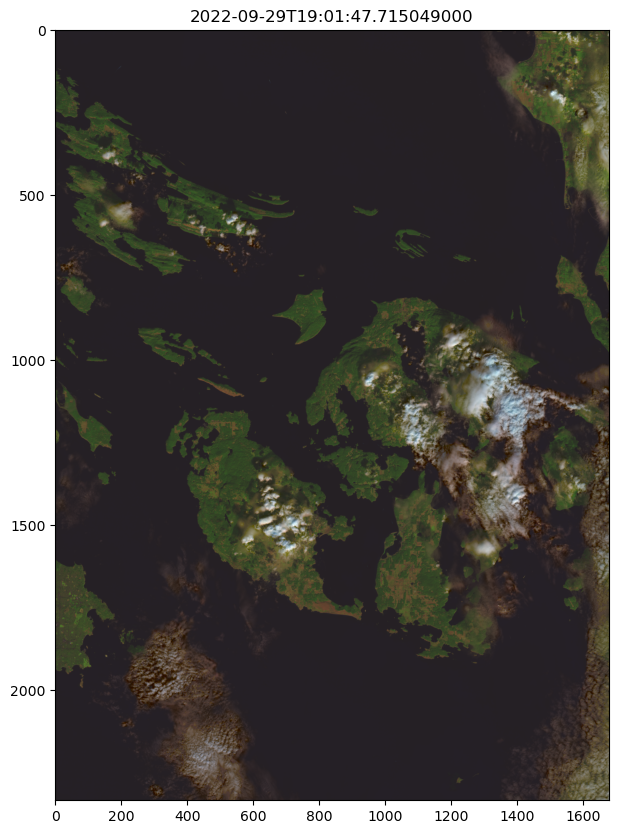

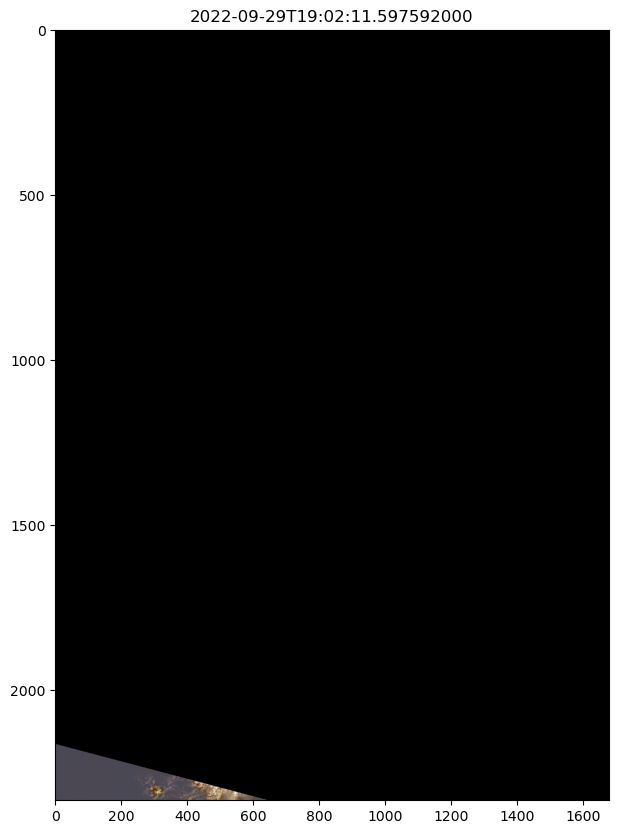

In [51]:
for fn in files:
    this_ds = xr.open_dataset(fn)
    # Plot a RGB from SWIR/NIR/BLUE to see what this dataset looks like
    this_ds['swir16_normalized'] = this_ds['swir16'] / np.max(this_ds['swir16'])
    this_ds['nir08_normalized'] = this_ds['nir08'] / np.max(this_ds['nir08'])
    this_ds['blue_normalized'] = this_ds['blue'] / np.max(this_ds['blue'])

    # Combine banthis_ds into an RGB image
    rgb_image = np.stack([
        this_ds['swir16_normalized'].values,
        this_ds['nir08_normalized'].values,
        this_ds['blue_normalized'].values
    ], axis=-1)
    
    # Plot the RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image)
    plt.title(this_ds.time.values)
    plt.show()